**Creating U-Net**

In [23]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout

In [8]:
def UNET(n_classes=4, imgh=256, imgw=256, imgc=1):
  inputs=Input((imgh,imgw,imgc))
  s=inputs
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)
    
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)
     
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)
     
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #up path 
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs= Conv2D(n_classes, (1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

**Importing Dependencies**

In [9]:
import os
import cv2
import numpy as np
from keras.utils import normalize
import glob
import matplotlib.pyplot as plt
import math

In [10]:
os.chdir('C:\\Users\\vibhu\\OneDrive\\Documents\\env\\projects\\sandstone_data_for_ML\\full_labels_for_deep_learning\\128_patches')

**Extracting images from .tiff format**

In [11]:
from PIL import Image
img = Image.open(os.path.join('images_as_128x128_patches.tif'))

for i in range(1600):
    try:
        img.seek(i)
        img.save('page_%s.tif'%(i,))
    except EOFError:
        print('exception')

**Storing images in numpy array**

In [12]:
SIZE_X=128
SIZE_Y=128
n_classes=4

train_images=[]
for directory_path in glob.glob(os.path.join("image")):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
        
train_images = np.array(train_images, dtype='uint8')

train_masks = [] 
for directory_path in glob.glob(os.path.join("mask")):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
               
train_masks = np.array(train_masks, dtype='uint8')

In [13]:
train_images.shape

(1600, 128, 128)

In [14]:
train_masks.shape

(1600, 128, 128)

**Label Encoding**

In [15]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

C:\Users\vibhu\OneDrive\Documents\env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
train_images.shape

(1600, 128, 128, 1)

In [17]:
train_masks.shape

(1600, 128, 128)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


**One-Hot Encoding**

In [19]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

**Balancing weights of classes**

In [20]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes=np.unique(train_masks_reshaped_encoded), y=train_masks_reshaped_encoded)
class_weights

array([1.93354786, 3.07345989, 0.32786918, 9.30640739])

**Model Training**

In [21]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

model=UNET(n_classes=n_classes, imgh=IMG_HEIGHT, imgw=IMG_WIDTH, imgc=IMG_CHANNELS)
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['Accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [25]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/20
90/90 [==============================] - 25s 65ms/step - loss: 0.7386 - Accuracy: 0.7955 - val_loss: 0.4373 - val_Accuracy: 0.8808
Epoch 2/20
90/90 [==============================] - 5s 60ms/step - loss: 0.4214 - Accuracy: 0.8753 - val_loss: 0.3682 - val_Accuracy: 0.8809
Epoch 3/20
90/90 [==============================] - 5s 61ms/step - loss: 0.3483 - Accuracy: 0.8828 - val_loss: 0.3108 - val_Accuracy: 0.8876
Epoch 4/20
90/90 [==============================] - 6s 63ms/step - loss: 0.3103 - Accuracy: 0.8888 - val_loss: 0.2472 - val_Accuracy: 0.9122
Epoch 5/20
90/90 [==============================] - 6s 63ms/step - loss: 0.2505 - Accuracy: 0.9124 - val_loss: 0.2171 - val_Accuracy: 0.9237
Epoch 6/20
90/90 [==============================] - 6s 63ms/step - loss: 0.2185 - Accuracy: 0.9244 - val_loss: 0.2170 - val_Accuracy: 0.9229
Epoch 7/20
90/90 [==============================] - 6s 64ms/step - loss: 0.2007 - Accuracy: 0.9310 - val_loss: 0.1943 - val_Accuracy: 0.9315
Epoch 8/20
9

**Results & Graphs**

In [27]:
_, acc = model.evaluate(X_test, y_test_cat)
print(f"Accuracy is = {math.floor((acc * 100.0))} %")

5/5 [==============================] - 1s 29ms/step - loss: 0.1285 - Accuracy: 0.9530
Accuracy is = 95 %


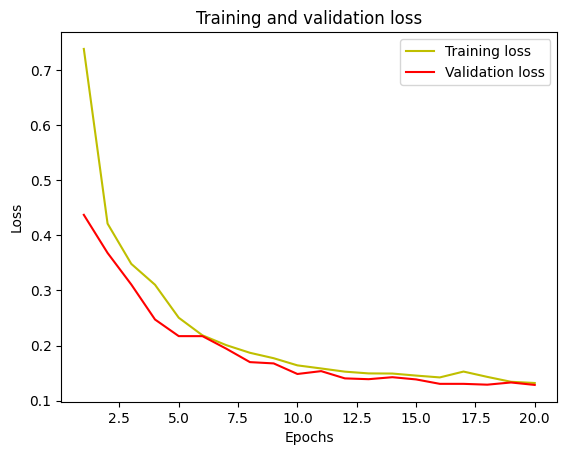

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

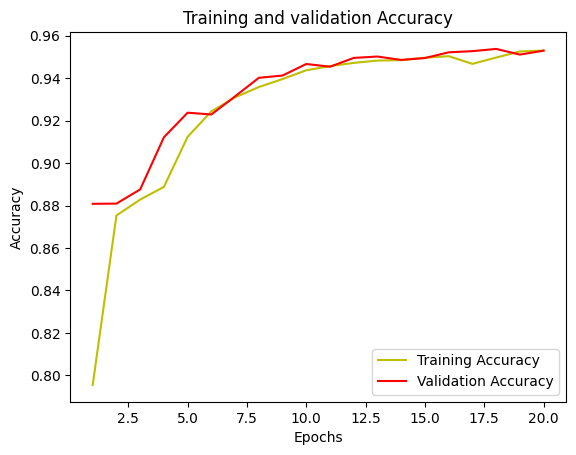

In [29]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Calculating Intersection over Union**

In [30]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

5/5 [==============================] - 0s 27ms/step


In [31]:
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.82944804


[[3.19967e+05 1.98200e+04 1.69620e+04 3.00000e+00]
 [6.54700e+03 1.39907e+05 5.52450e+04 8.00000e+00]
 [2.53300e+03 1.54280e+04 1.97839e+06 3.95900e+03]
 [0.00000e+00 0.00000e+00 2.73400e+03 5.99370e+04]]
IoU for class1 is:  0.87462825
IoU for class2 is:  0.590437
IoU for class3 is:  0.9533256
IoU for class4 is:  0.89940125


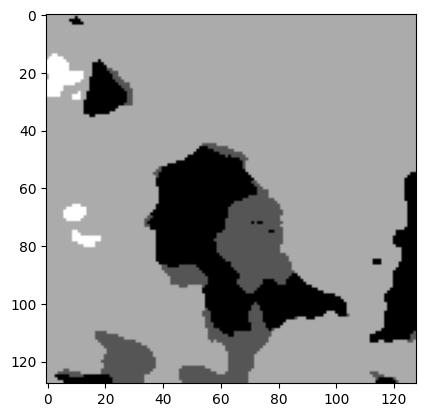

In [32]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

**Plotting a random image**

1/1 [==============================] - 0s 26ms/step


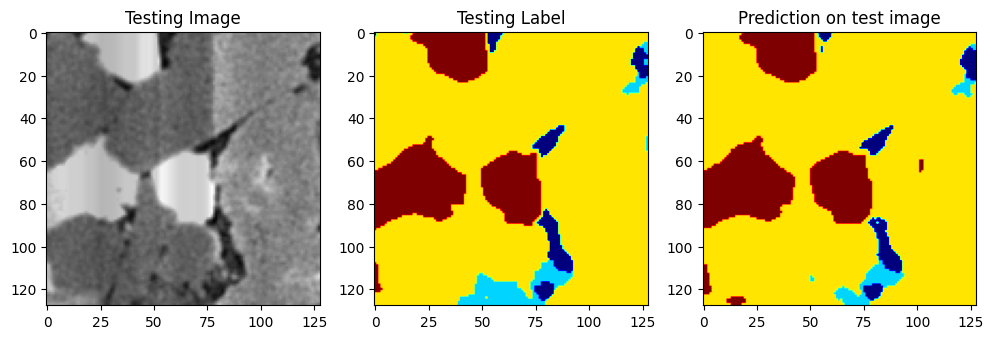

In [35]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()